In [1]:
from fastai import *
from fastai.vision import *

In [2]:
folder = "underconstruction"
file = "under.csv"

In [3]:
folder = "completed"
file = "full.csv"

In [7]:
## create folders and download images
path = Path("data/roads")
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [10]:
!pip install opencv-python

     |████████████████████████████████| 28.2 MB 154 kB/s eta 0:00:01     |████████████████▉               | 14.8 MB 260 kB/s eta 0:00:52


In [9]:
!python download_images.py --urls {path/file} --output {dest}

Traceback (most recent call last):
  File "download_images.py", line 5, in <module>
    from imutils import paths
  File "/home/vinc3/anaconda3/lib/python3.7/site-packages/imutils/__init__.py", line 8, in <module>
    from .convenience import translate
  File "/home/vinc3/anaconda3/lib/python3.7/site-packages/imutils/convenience.py", line 6, in <module>
    import cv2
ModuleNotFoundError: No module named 'cv2'


In [66]:
classes = ['underconstruction','completed']

In [67]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

underconstruction


completed


In [70]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms = get_transforms(), size = 224, num_workers=4).normalize(imagenet_stats)

In [71]:
data.classes

['completed', 'underconstruction']

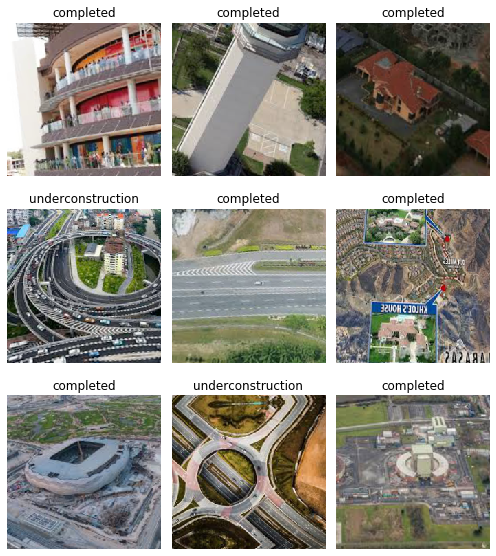

In [72]:
data.show_batch(rows=3,figsize=(7,8))

In [91]:
len(data.train_ds),len(data.valid_ds)

(576, 144)

## Train the model

In [82]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [83]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.267163,1.066354,0.611111,00:03
1,1.199323,1.150287,0.555556,00:03
2,1.055952,0.990053,0.611111,00:03
3,0.958207,0.966890,0.611111,00:03


In [85]:
learn.save('stage-1')

In [93]:
learn.unfreeze()

In [89]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


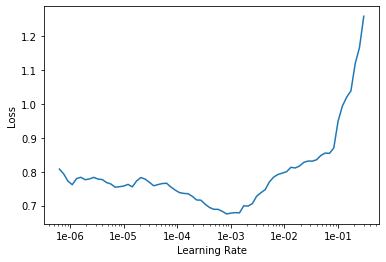

In [90]:
learn.recorder.plot()

In [94]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.401873,1.196767,0.638889,00:03
1,0.330833,1.274459,0.645833,00:03
2,0.340673,1.476286,0.625000,00:03
3,0.361169,1.674914,0.590278,00:03
4,0.348554,1.329339,0.638889,00:03
5,0.335328,1.376970,0.611111,00:03
6,0.316286,1.325118,0.611111,00:03
7,0.296276,1.398727,0.597222,00:03
8,0.270884,1.388949,0.583333,00:03
9,0.247191,1.397236,0.569444,00:03


In [95]:
learn.save('stage-2')

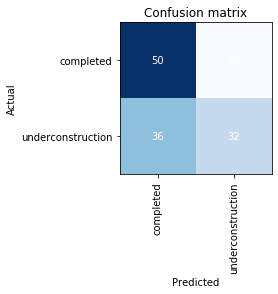

In [96]:
## interpretation
learn.load('stage-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()



## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.


In [97]:
from fastai.widgets import *

In [98]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [99]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [100]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [101]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())